In [1]:
# STEP 1: Install dependencies
!pip install transformers scikit-learn torch matplotlib seaborn --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 47.7 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
data_path = "/content/gdrive/MyDrive/Code/Restaurent_data/augmented_data_restaurant_bert.csv"
df = pd.read_csv(data_path)
df = df[['text', 'aspect_category']].dropna().reset_index(drop=True)


In [7]:
print(df.columns)


Index(['id', 'text', 'aspect_term', 'aspect_category', 'polarity', 'label_id'], dtype='object')


In [8]:
import pandas as pd
import numpy as np
import torch
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv("/content/gdrive/MyDrive/Code/Restaurent_data/augmented_data_restaurant_bert.csv")

# Assuming 'aspect_category' is the column you want to encode as labels
# If not, replace 'aspect_category' with the correct column name
df['label_id'] = label_encoder.fit_transform(df['aspect_category'])

# Combine sentence and aspect
# Assuming you have 'sentence' and 'aspect' columns in your DataFrame
# If not, replace them with the correct column names
df['input_text'] = df['text'] + " [ASPECT] " + df['aspect_term']

# Train, validation, test split
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label_id'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label_id'])

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 4261, Val: 913, Test: 914


In [9]:
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 128

class ABSADataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['input_text']
        label = self.data.iloc[idx]['label_id']
        inputs = tokenizer(text, padding='max_length', truncation=True, max_length=MAX_LEN, return_tensors='pt')
        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

train_loader = DataLoader(ABSADataset(train_df), batch_size=16, shuffle=True)
val_loader = DataLoader(ABSADataset(val_df), batch_size=16)
test_loader = DataLoader(ABSADataset(test_df), batch_size=16)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
import torch.nn as nn
from transformers import BertModel

class GANBERT_ABSA(nn.Module):
    def __init__(self, num_labels):
        super(GANBERT_ABSA, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.classifier = nn.Linear(768, num_labels)

        self.generator = nn.Sequential(
            nn.Linear(100, 768),
            nn.ReLU(),
            nn.Linear(768, 768)
        )

        self.discriminator = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Linear(512, num_labels + 1)  # +1 for fake
        )

    def forward(self, input_ids=None, attention_mask=None, z=None, mode='supervised'):
        if mode == 'supervised':
            out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            cls_out = out.last_hidden_state[:, 0, :]
            return self.classifier(cls_out), self.discriminator(cls_out)

        elif mode == 'generator':
            gen_feat = self.generator(z)
            return self.discriminator(gen_feat)

        elif mode == 'discriminator':
            out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            cls_out = out.last_hidden_state[:, 0, :]
            return self.discriminator(cls_out)


In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(model, dataloader, name="Validation"):
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for batch in dataloader:
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            logits, _ = model(input_ids=ids, attention_mask=mask)
            pred = torch.argmax(logits, dim=1)

            preds.extend(pred.cpu().numpy())
            targets.extend(labels.cpu().numpy())

    print(f"\n📊 {name} Classification Report:")
    print(classification_report(targets, preds, target_names=label_encoder.classes_))

    cm = confusion_matrix(targets, preds)
    sns.heatmap(cm, annot=True, cmap="Blues", fmt='g', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


In [13]:
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 128

class ABSADataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['input_text']
        # Ensure 'text' is a string by converting it
        text = str(text)
        label = self.data.iloc[idx]['label_id']
        inputs = tokenizer(text, padding='max_length', truncation=True, max_length=MAX_LEN, return_tensors='pt')
        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

train_loader = DataLoader(ABSADataset(train_df), batch_size=16, shuffle=True)
val_loader = DataLoader(ABSADataset(val_df), batch_size=16)
test_loader = DataLoader(ABSADataset(test_df), batch_size=16)


📊 Test Classification Report:
                         precision    recall  f1-score   support

               ambience       0.18      0.09      0.12       118
anecdotes/miscellaneous       0.37      0.99      0.53       314
                   food       0.00      0.00      0.00       254
                  price       0.00      0.00      0.00        85
                service       0.00      0.00      0.00       143

               accuracy                           0.35       914
              macro avg       0.11      0.22      0.13       914
           weighted avg       0.15      0.35      0.20       914



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


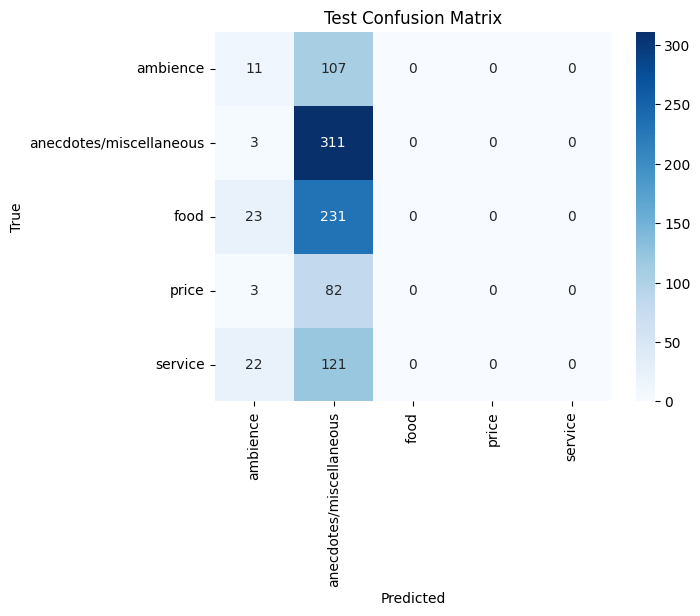

In [14]:
# Load model (if needed)
# model.load_state_dict(torch.load("gan_bert_absa_model.pth"))
evaluate(model, test_loader, name="Test")
